# Purpose: Predicting Optimal AFP Parameters for Targeted Mechanical Properties Using WGANs Model as VSG Technique Combine With a MLP Model as Predictive Model
# Date: 05/2025
# UNSW Sydney / EPFL
# Code: Assier de Pompignan Leo

2/2 [==============================] - 0s 0s/step
Epoch 0/5000, Critic Loss Real: -0.0001340683811577037, Critic Loss Fake: 0.00017451084568165243, Generator Loss: -0.0001018655311781913
2/2 [==============================] - 0s 0s/step
Epoch 500/5000, Critic Loss Real: -0.002846368821337819, Critic Loss Fake: 0.002812315011397004, Generator Loss: -0.0026625366881489754
2/2 [==============================] - 0s 1ms/step
Epoch 1000/5000, Critic Loss Real: -0.0017497657099738717, Critic Loss Fake: 0.0017807811964303255, Generator Loss: -0.0016619858797639608
2/2 [==============================] - 0s 2ms/step
Epoch 1500/5000, Critic Loss Real: -0.00195743958465755, Critic Loss Fake: 0.001958292443305254, Generator Loss: -0.001817483687773347
2/2 [==============================] - 0s 1ms/step
Epoch 2000/5000, Critic Loss Real: -0.0019812684040516615, Critic Loss Fake: 0.002032965887337923, Generator Loss: -0.0018777439836412668
2/2 [==============================] - 0s 3ms/step
Epoch 2500/

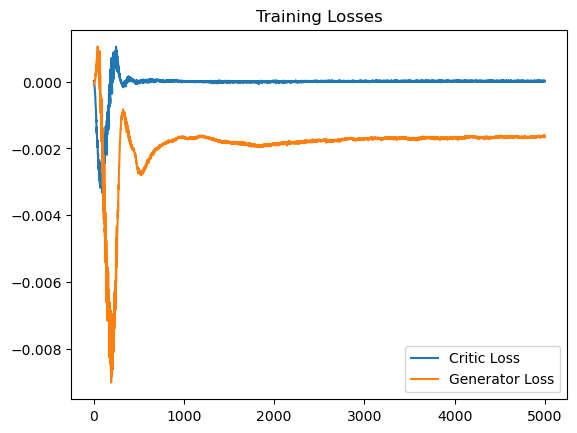

32/32 [==============================] - 0s 632us/step
Virtual samples generated and saved.


In [1]:
# WGANs Model used as a VSG Technique
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Parameters for WGAN
num_virtual_samples = 1000
latent_dim = 10
epochs = 5000
batch_size = 64
critic_iterations = 5
weight_clip_value = 0.01

# Load original data
data_path = 'training_dataset.xlsx'
original_data = pd.read_excel(data_path, skiprows=1)
original_data.columns = original_data.columns.str.strip()

# Select input and output columns
X_original = original_data[['Modulus (Gpa)', 'ILSS (Mpa)', 'Max bending stress (Mpa)', 'Max strain (mm/mm)', 'Thickness (mm)']].values
y_original = original_data[['Consolidation force (N)', 'Deposition rate (mm/s)', 'Hot gas torch temperature (C)']].values

# Combine data for WGAN
full_data = np.concatenate([X_original, y_original], axis=1)
data_dim = full_data.shape[1]

# Normalize data
min_values = full_data.min(axis=0)
max_values = full_data.max(axis=0)
range_values = max_values - min_values
epsilon = 1e-8
range_values[range_values == 0] = epsilon
normalized_data = (full_data - min_values) / range_values

# Define WGAN components
def build_generator(latent_dim, data_dim):
    model = Sequential([
        Dense(64, input_dim=latent_dim),
        LeakyReLU(0.2),
        Dense(128),
        LeakyReLU(0.2),
        Dense(data_dim, activation='linear')
    ])
    return model

def build_critic(data_dim):
    model = Sequential([
        Dense(128, input_dim=data_dim),
        LeakyReLU(0.2),
        Dense(64),
        LeakyReLU(0.2),
        Dense(1, activation='linear')
    ])
    return model

# Wasserstein Loss
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

# Build Generator and Critic
generator = build_generator(latent_dim, data_dim)
critic = build_critic(data_dim)
critic.compile(optimizer=RMSprop(learning_rate=0.00005), loss=wasserstein_loss)

# Freeze Critic for WGAN training
critic.trainable = False
wgan = Sequential([generator, critic])
wgan.compile(optimizer=RMSprop(learning_rate=0.00005), loss=wasserstein_loss)

# Training WGAN
def train_wgan(data, generator, critic, wgan, epochs, batch_size, latent_dim, critic_iterations, weight_clip_value):
    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        for _ in range(critic_iterations):
            # Train Critic
            real_samples = data[np.random.randint(0, data.shape[0], batch_size)]
            fake_samples = generator.predict(np.random.normal(0, 1, (batch_size, latent_dim)))
            real_labels = -np.ones((batch_size, 1))
            fake_labels = np.ones((batch_size, 1))

            d_loss_real = critic.train_on_batch(real_samples, real_labels)
            d_loss_fake = critic.train_on_batch(fake_samples, fake_labels)

            # Clip weights of the critic
            for layer in critic.layers:
                weights = layer.get_weights()
                weights = [np.clip(w, -weight_clip_value, weight_clip_value) for w in weights]
                layer.set_weights(weights)

        # Train Generator
        latent_points = np.random.normal(0, 1, (batch_size, latent_dim))
        misleading_labels = -np.ones((batch_size, 1))
        g_loss = wgan.train_on_batch(latent_points, misleading_labels)

        d_losses.append((d_loss_real + d_loss_fake) / 2)
        g_losses.append(g_loss)

        if epoch % 500 == 0:
            print(f"Epoch {epoch}/{epochs}, Critic Loss Real: {d_loss_real}, Critic Loss Fake: {d_loss_fake}, Generator Loss: {g_loss}")

    # Plot training losses
    plt.plot(d_losses, label="Critic Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.legend()
    plt.title("Training Losses")
    plt.show()

train_wgan(normalized_data, generator, critic, wgan, epochs, batch_size, latent_dim, critic_iterations, weight_clip_value)

# Generate Virtual Samples
latent_points = np.random.normal(0, 1, (num_virtual_samples, latent_dim))
generated_data = generator.predict(latent_points)
denormalized_data = generated_data * range_values + min_values

# Split into input and output
X_vsg = denormalized_data[:, :5]
y_vsg = denormalized_data[:, 5:]

# Save data
vsg_data = pd.DataFrame(np.concatenate([X_vsg, y_vsg], axis=1),
                        columns=['Modulus (Gpa)', 'ILSS (Mpa)', 'Max bending stress (Mpa)', 'Max strain (mm/mm)', 'Thickness (mm)',
                                 'Consolidation force (N)', 'Deposition rate (mm/s)', 'Hot gas torch temperature (C)'])
vsg_data.to_csv('generated_vsg_data_wgan.csv', index=False)
print("Virtual samples generated and saved.")


Epoch 1/2000
26/26 [==============================] - 1s 8ms/step - loss: 0.9624 - val_loss: 0.8195
Epoch 2/2000
26/26 [==============================] - 0s 5ms/step - loss: 0.7647 - val_loss: 0.7413
Epoch 3/2000
26/26 [==============================] - 0s 5ms/step - loss: 0.6833 - val_loss: 0.6133
Epoch 4/2000
26/26 [==============================] - 0s 4ms/step - loss: 0.6226 - val_loss: 0.5500
Epoch 5/2000
26/26 [==============================] - 0s 4ms/step - loss: 0.5421 - val_loss: 0.4525
Epoch 6/2000
26/26 [==============================] - 0s 4ms/step - loss: 0.4933 - val_loss: 0.4073
Epoch 7/2000
26/26 [==============================] - 0s 4ms/step - loss: 0.4649 - val_loss: 0.4057
Epoch 8/2000
26/26 [==============================] - 0s 4ms/step - loss: 0.4248 - val_loss: 0.3691
Epoch 9/2000
26/26 [==============================] - 0s 3ms/step - loss: 0.4154 - val_loss: 0.3816
Epoch 10/2000
26/26 [==============================] - 0s 3ms/step - loss: 0.4043 - val_loss: 0.4126

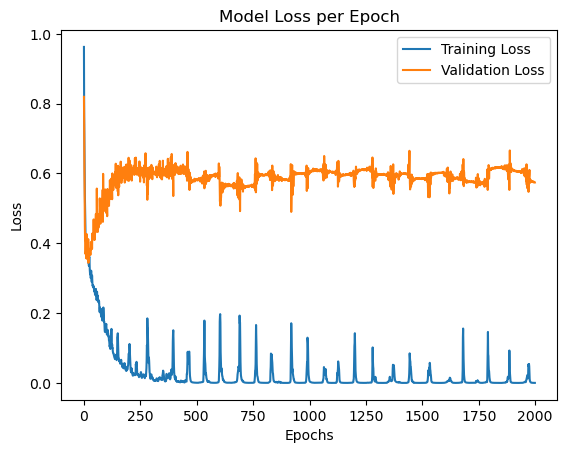

Model training complete and saved.


In [2]:
# MLP Model used as a Predictive Model
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

# File paths
file_path_real = 'training_dataset.xlsx'
file_path_vsg = 'generated_vsg_data_wgan.csv'

# Load real and virtual data
data_real = pd.read_excel(file_path_real, skiprows=1)
data_real.columns = data_real.columns.str.strip()

data_vsg = pd.read_csv(file_path_vsg)

# Combine data
X_combined = np.concatenate([
    data_real[['Modulus (Gpa)', 'ILSS (Mpa)', 'Max bending stress (Mpa)', 'Max strain (mm/mm)', 'Thickness (mm)']].values,
    data_vsg[['Modulus (Gpa)', 'ILSS (Mpa)', 'Max bending stress (Mpa)', 'Max strain (mm/mm)', 'Thickness (mm)']].values
], axis=0)
y_combined = np.concatenate([
    data_real[['Consolidation force (N)', 'Deposition rate (mm/s)', 'Hot gas torch temperature (C)']].values,
    data_vsg[['Consolidation force (N)', 'Deposition rate (mm/s)', 'Hot gas torch temperature (C)']].values
], axis=0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Train model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(3)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train_scaled, y_train_scaled, epochs=2000, batch_size=32, validation_data=(X_test_scaled, y_test_scaled))

# Plot loss as a function of epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Save model and scalers
model.save('trained_model_tf_wgan.h5')
joblib.dump(scaler_X, 'scaler_X_wgan.pkl')
joblib.dump(scaler_y, 'scaler_y_wgan.pkl')

print("Model training complete and saved.")

In [3]:
# Inference code
import pandas as pd
import tensorflow as tf
import joblib

# Load model and scalers
model = tf.keras.models.load_model('trained_model_tf_wgan.h5')
scaler_X = joblib.load('scaler_X_wgan.pkl')
scaler_y = joblib.load('scaler_y_wgan.pkl')

# Load new data
file_path_new = 'training_test.xlsx'
new_data = pd.read_excel(file_path_new, skiprows=1)
new_data.columns = new_data.columns.str.strip()

X_new = new_data[['Modulus (Gpa)', 'ILSS (Mpa)', 'Max bending stress (Mpa)', 'Max strain (mm/mm)', 'Thickness (mm)']].values
X_new = pd.DataFrame(X_new).fillna(X_new.mean()).values
X_new_scaled = scaler_X.transform(X_new)

# Predict
y_pred_scaled = model.predict(X_new_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Save predictions
prediction_df = pd.DataFrame(y_pred, columns=['Consolidation force (N)', 'Deposition rate (mm/s)', 'Hot gas torch temperature (C)'])
print("Predictions:")
print(prediction_df)

# File paths
output_file_path = 'predictions_WGANs_MLP.xlsx'  # Output Excel file path

# Add the file name to the top of the DataFrame
file_name = file_path_new.split('/')[-1]  # Extract file name from the path
file_header = pd.DataFrame([[file_name, file_name, file_name]], columns=prediction_df.columns)  # Update for 3 columns
output_df = pd.concat([file_header, prediction_df], ignore_index=True)

# Save to Excel
output_df.to_excel(output_file_path, index=False)
print(f"Predictions saved to {output_file_path}")


1/1 [==============================] - 0s 50ms/step
Predictions:
    Consolidation force (N)  Deposition rate (mm/s)  \
0                180.500549               75.896767   
1                249.348709               75.983131   
2                282.454651               73.092995   
3                422.048462               77.189461   
4                180.200089               76.104416   
5                249.942490               76.077911   
6                348.363831               75.950737   
7                449.709198               75.916542   
8                180.422394               76.041672   
9                249.479126               76.111679   
10               370.520660               76.588013   
11               450.165222               76.035637   
12               181.057999               76.004974   
13               250.206070               75.992874   
14               349.846161               76.143517   
15               449.910675               75.858429   
